# Metabolon pilot Human Metabolite Disease Network

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests

c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Processing datasets

In [72]:

class MetabolonDataset:
    '''
    Class to load and QC metabolon data
    '''
    def __init__(self, file_path, id, node_name, first_row_index, first_col_index, identifiers_row, md_sampname, md_group, md_filter):
        self.file_path = file_path
        self.raw_data = None
        self.compound_mappers = None
        self.processed_data = None
        self.metadata = None
        self.id = id
        self.node_name = node_name
        self.first_row_index = first_row_index
        self.first_col_index = first_col_index
        self.identifiers_row = identifiers_row
        self.md_sampname = md_sampname
        self.md_group = md_group
        self.md_filter = md_filter
        self.DA_metabolites = None

        self.read_data(file_path)
        self.preprocess_data()
        self.da_testing()
        
    def read_data(self, file_path):
        """
        Read in the metabolon data
        """
        # read in the data
        data = pd.read_excel(file_path + '/peaktable.xlsx', header=None)
        self.raw_data = data

        metadata = pd.read_csv(file_path + '/s_' + self.id + '.txt', sep = '\t')

        self.metadata = metadata
        self.metadata[self.md_sampname] = self.metadata[self.md_sampname].astype(str)
        print(metadata[[self.md_sampname, self.md_group]].head())

        return data, metadata

    def preprocess_data(self):
        data_filt = self.raw_data.copy()
        data_filt.index = data_filt.iloc[:, 0]
        data_filt.columns = data_filt.iloc[self.identifiers_row, :].astype(str)
        data_filt = data_filt.iloc[self.first_row_index:, self.first_col_index:]

        # ensure all data is numeric
        data_filt = data_filt.apply(pd.to_numeric, errors='coerce')

        # Transpose
        data_filt = data_filt.T

        # Missingness checks 
        # replace empty strings with NaN
        data_filt = data_filt.replace(['', ' '], np.nan)
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        data_filt = data_filt.dropna(axis=1, thresh=0.3*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
        print(f"Missingness: {missing_pct:.2f}%")

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        # add metadata column
        md_dict = dict(zip(self.metadata[self.md_sampname], self.metadata[self.md_group]))
        data_scaled['Group'] = data_scaled.index.map(md_dict)


        # filter on metadata
        # TODO check whether to rescale after filtering
        data_scaled = data_scaled[data_scaled['Group'].isin(self.md_filter)]

        self.processed_data = data_scaled

        return data_scaled
    
    def plot_qc(self):
        
        # PCA biplot
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result[:, 0], y=pca_result[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = (self.processed_data.shape[1] - 1) / 20
        sns.boxplot(data=self.processed_data.iloc[:, ::50], ax=ax2)
        plt.show()

    def da_testing(self):

        # t-test for two groups
        groups = self.processed_data['Group'].unique()
        stat, pvals = stats.ttest_ind(self.processed_data[self.processed_data['Group'] == groups[0]].iloc[:, :-1],
                        self.processed_data[self.processed_data['Group'] == groups[1]].iloc[:, :-1],
                        alternative='two-sided')
        pval_df = pd.DataFrame(pvals, index=self.processed_data.columns[:-1], columns=['P-value'])

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
    


In [73]:
erbc_data = MetabolonDataset(
    file_path = 'MTBLS3342', 
    id = 'MTBLS3342', 
    node_name = 'estrogen receptor positive breast cancers', 
    first_row_index = 5, 
    first_col_index = 6, 
    identifiers_row=0,
    md_sampname='Source Name',
    md_group = 'Factor Value[IACS Response]',
    md_filter=['responder', 'resistant'])

  Source Name Factor Value[IACS Response]
0  4047077212                   responder
1  4047077224                   resistant
2  4047078340                   resistant
3  4047078342                   resistant
4  4047078344                   resistant
Missingness: 5.26%
Number of differentially abundant metabolites: 596


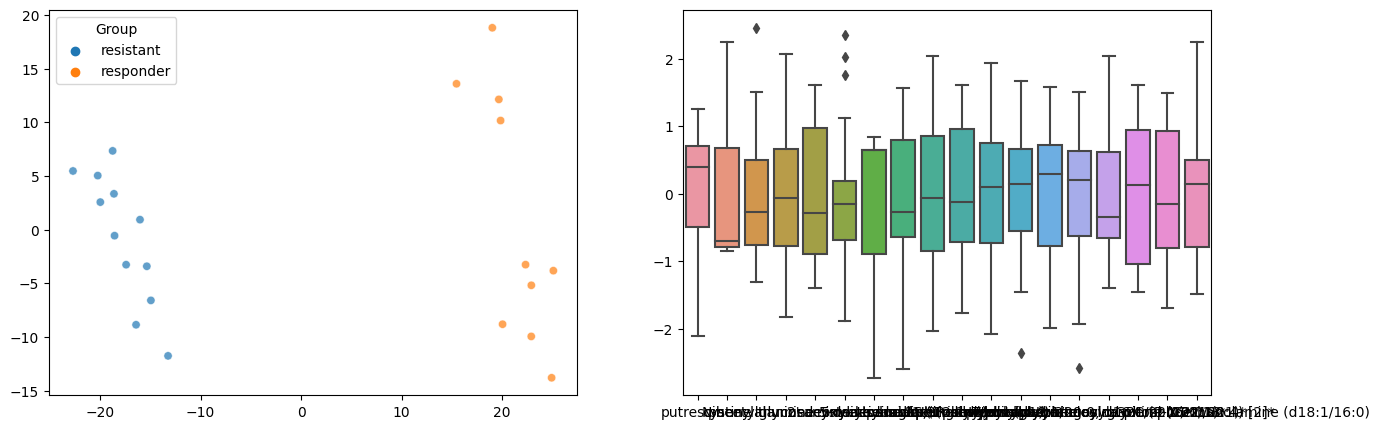

In [61]:
erbc_data.plot_qc()

In [74]:

pmh_data = MetabolonDataset(
    file_path = 'MTBLS136', 
    id = 'MTBLS136', 
    node_name = 'PMH', 
    first_row_index=4, 
    first_col_index=9, 
    identifiers_row=1,
    md_sampname='Sample Name',
    md_group='Factor Value[CurrentPMH]',
    md_filter=['Nonuser', 'E-only']
    )


  Sample Name Factor Value[CurrentPMH]
0   063459_01                  Nonuser
1   081531_03                   E-only
2  022817_136                      NaN
3   079243_03                  Nonuser
4   034993_02                   E-only
Missingness: 10.17%
Number of differentially abundant metabolites: 612


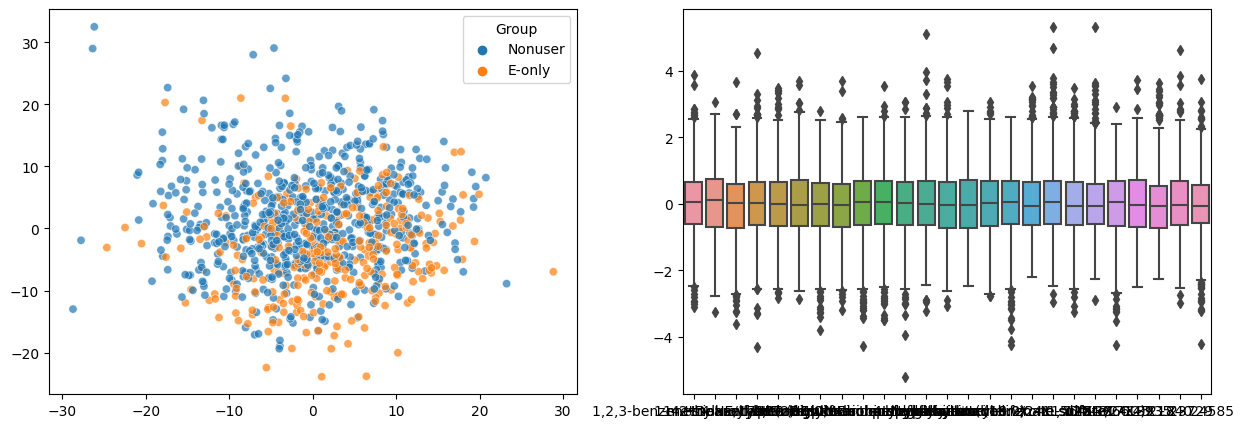

In [75]:
pmh_data.plot_qc()

In [76]:
preterm_data = MetabolonDataset(
    file_path = 'MTBLS702',
    id = 'MTBLS702',
    node_name = 'Preterm',
    first_row_index=2,
    first_col_index=6,
    identifiers_row=1,
    md_sampname='Sample Name',
    md_group='Factor Value[Race]',
    md_filter=['Black', 'White']
    )


  Sample Name Factor Value[Race]
0  UNPA-02736              Black
1  UNPA-02740              Black
2  UNPA-02745              Black
3  UNPA-02749              Black
4  UNPA-02750              Black
Missingness: 22.13%
Number of differentially abundant metabolites: 22


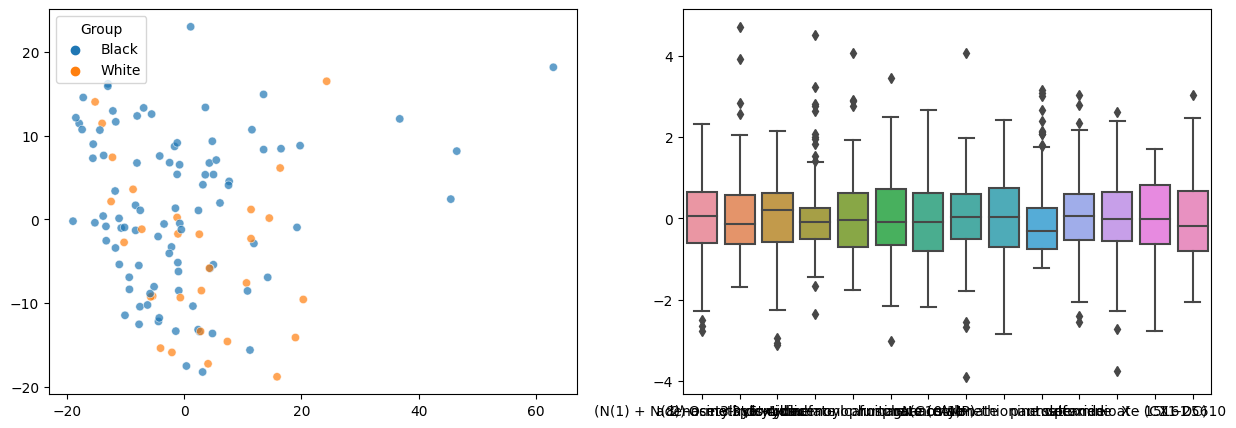

In [66]:
preterm_data.plot_qc()

In [77]:

sct_data = MetabolonDataset(
    file_path = 'MTBLS406', 
    id = 'MTBLS406', 
    node_name = 'Stem cell transplant', 
    first_row_index = 3, 
    first_col_index = 6, 
    identifiers_row=1,
    md_sampname='Source Name',
    md_group = 'Factor Value[Gender]',
    md_filter=['Male', 'Female']
    )

      Source Name Factor Value[Gender]
0  BG111_24_02_14                 Male
1  ME114_24_02_14               Female
2  GD112_25_02_14                 Male
3  BG111_10_03_14                 Male
4  ME114_10_03_14               Female
Missingness: 8.37%
Number of differentially abundant metabolites: 213


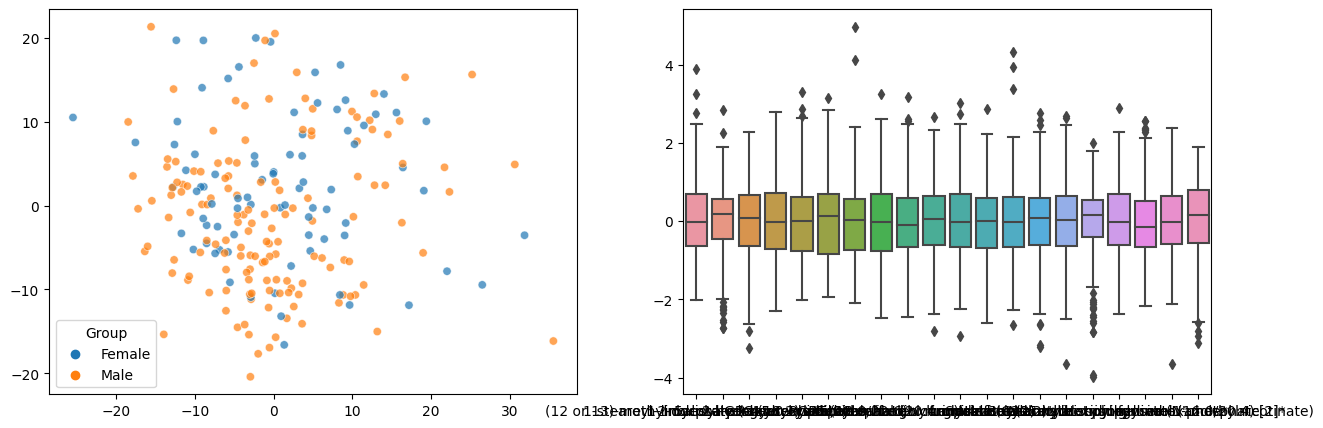

In [17]:
sct_data.plot_qc()

In [5]:
# all_data = MetabolonDataset(
#     file_path = 'MTBLS2394', 
#     id = 'MTBLS2394', 
#     node_name = 'Acute lymphoblastic leukemia', 
#     first_row_index = 2, 
#     first_col_index = 7, 
#     identifiers_row=1,
#     md_sampname='Source Name',
#     md_group = 'Factor Value[Time Point]',
#     md_filter=['inital time point', 'post time point']
#     )

     Source Name Factor Value[Time Point]
0            P01       initial time point
1            P02       initial time point
2            P04       initial time point
3            P05       initial time point
4            P06       initial time point
..           ...                      ...
103  unassigned4                      NaN
104  unassigned5                      NaN
105  unassigned6                      NaN
106  unassigned7                      NaN
107  unassigned8                      NaN

[108 rows x 2 columns]


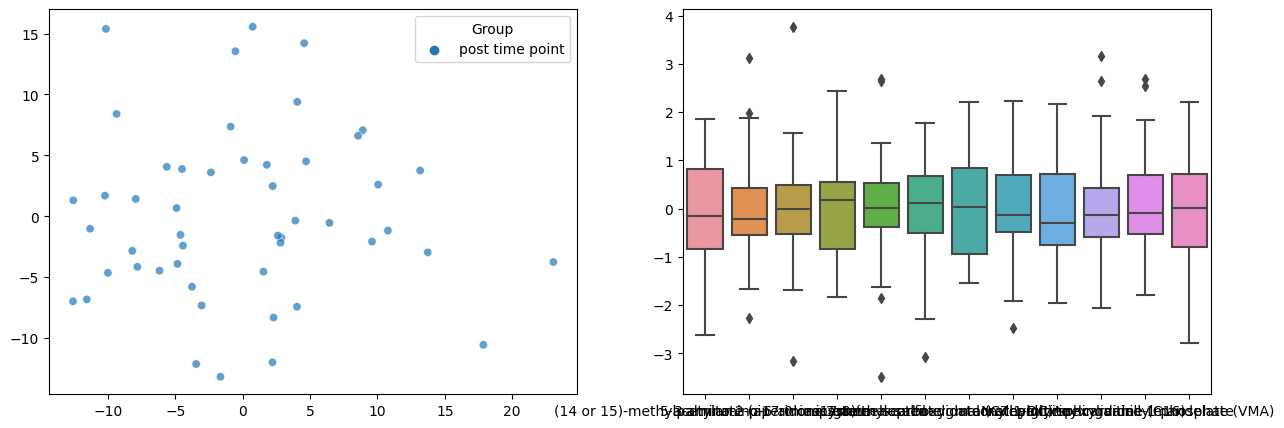

In [7]:
all_data.plot_qc()

In [78]:
import networkx as nx

In [79]:
from networkx.algorithms import bipartite
B = nx.Graph()
# Add nodes with the node attribute "bipartite"-
B.add_nodes_from([sct_data.node_name, pmh_data.node_name, preterm_data.node_name, erbc_data.node_name], bipartite=0)
B.add_nodes_from(sct_data.DA_metabolites + pmh_data.DA_metabolites + preterm_data.DA_metabolites + erbc_data.DA_metabolites, bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from(sct_data.connection + pmh_data.connection + preterm_data.connection + erbc_data.connection)

In [80]:
bottom_nodes, top_nodes = bipartite.sets(B)

In [81]:
nx.is_connected(B)

True

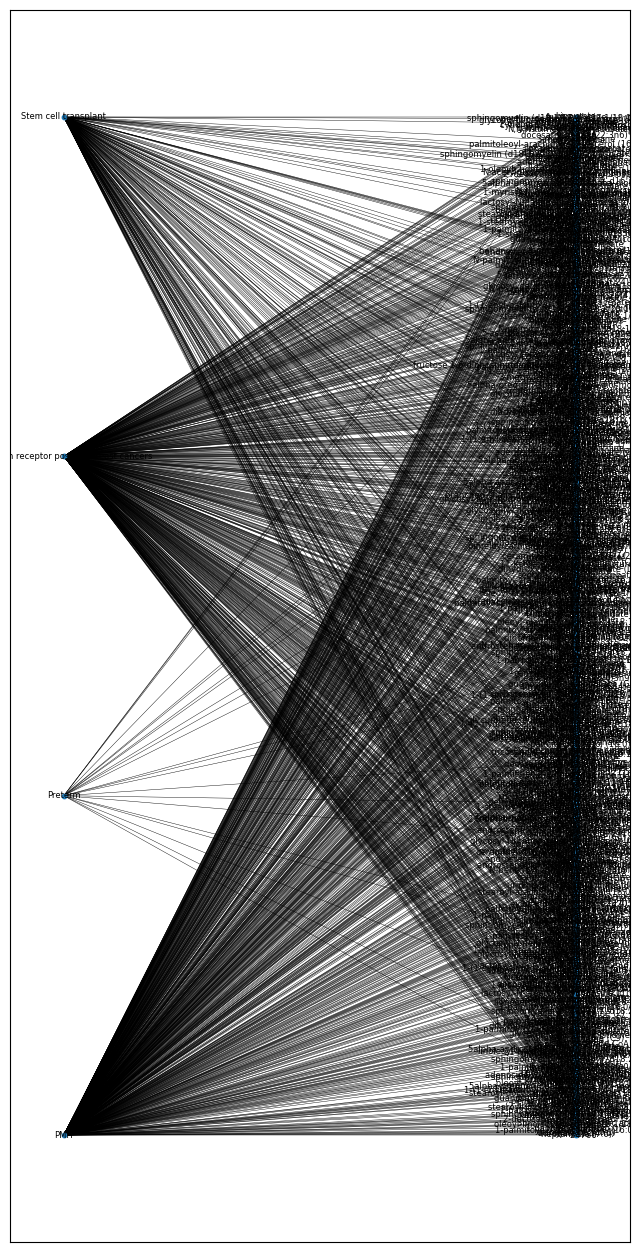

In [85]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    B,
    pos = nx.drawing.layout.bipartite_layout(B, bottom_nodes),
    font_size=6,
    width = 0.3,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()

In [86]:
# export gml for cytoscape
nx.write_graphml_lxml(B, "metabolon_HMDN.graphml")